In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, "../src")

from NNApproximator import NNApproximator
from util import DEVICE, infer_k, compute_trajectory, initialize_weights
from losses import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Load training data

In [2]:
df = pd.read_csv('../data/k=50_L=5_N=5_T=40s.csv')

tr_positions = df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y']][:2000]
tr_forces = df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y']][:2000]

val_positions = df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y']][2000:]
val_forces = df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y']][2000:]

tr_position_stack = np.vstack((
    tr_positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    tr_positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    tr_positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy()
))
tr_forces_stack = np.vstack((
    tr_forces[['rddot1_x','rddot1_y']].to_numpy(),
    tr_forces[['rddot2_x','rddot2_y']].to_numpy(),
    tr_forces[['rddot3_x','rddot3_y']].to_numpy()
))

val_positions_stack = np.vstack((
    val_positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    val_positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    val_positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy()
))
val_forces_stack = np.vstack((
    val_forces[['rddot1_x','rddot1_y']].to_numpy(),
    val_forces[['rddot2_x','rddot2_y']].to_numpy(),
    val_forces[['rddot3_x','rddot3_y']].to_numpy()
))

x = torch.from_numpy(tr_position_stack.copy()).float().to(DEVICE)
F = torch.from_numpy(tr_forces_stack.copy()).float().to(DEVICE)

x_tr = torch.vstack((
    x[:500,:].clone(),
    x[2000:2500,:].clone(),
    x[4000:4500,:].clone()
))
y_tr = torch.vstack((
    F[:500,:].clone(),
    F[2000:2500,:].clone(),
    F[4000:4500,:].clone()
))

x_collocation = x.clone().requires_grad_(True)

x_val = torch.from_numpy(val_positions_stack.copy()).float().requires_grad_(True).to(DEVICE)
y_val = torch.from_numpy(val_forces_stack.copy()).float().to(DEVICE)

# Train model

In [3]:
def train_model(model, data_loss_fn, PINN_loss_fn, PINN_weight=0, learning_rate=0.0001, max_epochs=1000, weight_decay=1e-3):
    model.train()
    tr_losses = []
    data_losses = []
    PINN_losses = []
    val_losses = []
    val_data_losses = []
    val_PINN_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    print("Using Adam optimizer ... ")
    log_iter = 1000
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 6000, 0.1, verbose=False)

    min_loss = 1e9

    for epoch in range(max_epochs):
        data_loss = data_loss_fn(model)
        PINN_loss = PINN_loss_fn(model)
        loss = data_loss + PINN_weight * PINN_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % log_iter == 0:
            print(f"Epoch: {epoch} - Loss: {float(loss):>7f} - Data: {float(data_loss):>7f} - PINN: {float(PINN_loss):>7f}")
            print(f"Loss over entire dataset: {float(compute_data_loss_force(model, x, F).detach()):>7f}") # TODO: fix preprocess_x

        tr_losses.append(loss.cpu().detach().numpy())
        data_losses.append(data_loss.cpu().detach().numpy())
        PINN_losses.append(PINN_loss.cpu().detach().numpy())

        val_data_loss = compute_data_loss_force(model, x_val, y_val)
        val_PINN_loss = compute_PINN_loss(model, x_val)
        val_loss = val_data_loss + PINN_weight * val_PINN_loss
        val_losses.append(val_loss.cpu().detach().numpy())
        val_data_losses.append(val_data_loss.cpu().detach().numpy())
        val_PINN_losses.append(val_PINN_loss.cpu().detach().numpy())

        if epoch > 2000 and loss.item() < 0.99 * min_loss:
            min_loss = loss.item()

    plt.figure(0)
    plt.semilogy(tr_losses, label="Total")
    plt.semilogy(data_losses, label="Data")
    plt.semilogy(PINN_losses, label="PINN")
    plt.legend()

    plt.figure(1)
    plt.semilogy(val_losses, label="Total")
    plt.semilogy(val_data_losses, label="Data")
    plt.semilogy(val_PINN_losses, label="PINN")
    plt.legend()

    print("Min loss: ", min_loss)

    return model, np.array(tr_losses)

Using Adam optimizer ... 
Epoch: 0 - Loss: 60773.050781 - Data: 232.980988 - PINN: 605.400696
Loss over entire dataset: 0.255431
Epoch: 1000 - Loss: 132.176636 - Data: 32.787617 - PINN: 0.993890
Loss over entire dataset: 0.040892
Epoch: 2000 - Loss: 22.834703 - Data: 2.025453 - PINN: 0.208092
Loss over entire dataset: 0.002405
Epoch: 3000 - Loss: 9.466404 - Data: 0.455874 - PINN: 0.090105
Loss over entire dataset: 0.000594
Epoch: 4000 - Loss: 5.039678 - Data: 0.163658 - PINN: 0.048760
Loss over entire dataset: 0.000269
Epoch: 5000 - Loss: 7.146296 - Data: 0.166029 - PINN: 0.069803
Loss over entire dataset: 0.000235
Epoch: 6000 - Loss: 2.252115 - Data: 0.062533 - PINN: 0.021896
Loss over entire dataset: 0.000150
Epoch: 7000 - Loss: 2.175559 - Data: 0.060659 - PINN: 0.021149
Loss over entire dataset: 0.000148
Epoch: 8000 - Loss: 2.061533 - Data: 0.057944 - PINN: 0.020036
Loss over entire dataset: 0.000143
Epoch: 9000 - Loss: 1.900895 - Data: 0.054423 - PINN: 0.018465
Loss over entire dat

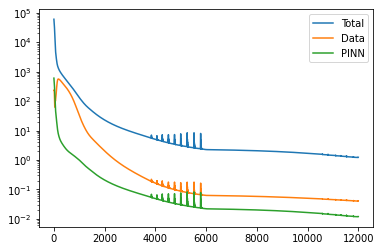

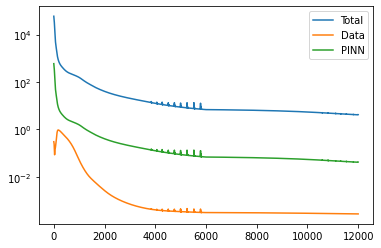

In [24]:
num_layer = 3
hidden_dim = 32
PINN_weight = 100
lr = 9e-4
epoch = 12000
wd = 1e-3

model = NNApproximator(num_hidden=num_layer, dim_hidden=hidden_dim).to(DEVICE)

model, tr_losses = train_model(
    model,
    data_loss_fn=lambda model: 1e3*compute_data_loss_force(model, x_tr, y_tr),
    PINN_loss_fn=lambda model: compute_PINN_loss(model, x_collocation),
    PINN_weight=PINN_weight,
    learning_rate=lr,
    max_epochs=epoch,
    weight_decay=wd,
)

# Compute trajectories with trained model

In [46]:
# compute NN-predicted closed-loop trajectories
N_m = 5
xLeft  = (tr_positions.iloc[0,:][['r0_x','r0_y']]).to_numpy()
xRight = (tr_positions.iloc[0,:][['r4_x','r4_y']]).to_numpy()
mass_cols = ['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']

# the vector 'x0' contains the initial positions of the *movable* masses
# i.e. x0.shape = [N_m * 2]
x0 = (tr_positions.iloc[0,:][mass_cols]).to_numpy()
x0dot = np.zeros_like(x0)

y, t = compute_trajectory(x0, x0dot, model, xLeft, xRight)

## Trajectories over trained region

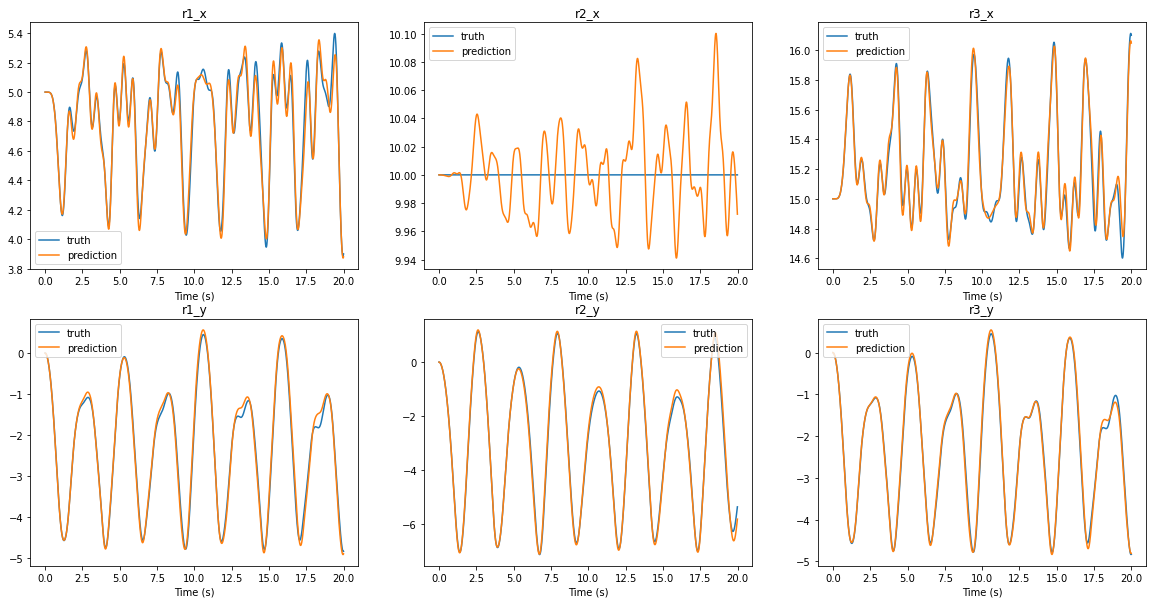

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'][:2000], tr_positions[mass_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(t[:2000], y.T[:2000,i], label='prediction')
  curr_ax.set_title(mass_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()
fig.savefig('train_trajectories_PINN=100_layer=3_dim=32.png')

## Trajectories over validation region

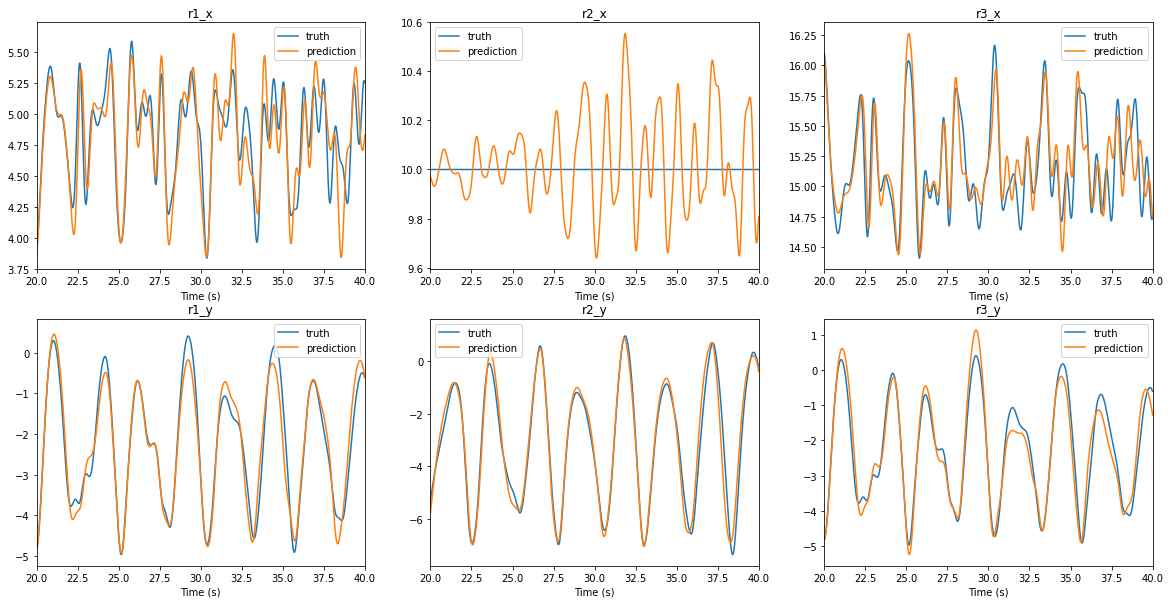

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'], np.hstack((tr_positions[mass_cols[i]].to_numpy(), val_positions[mass_cols[i]].to_numpy())), label='truth')
  curr_ax.plot(t, y.T[:,i], label='prediction')
  curr_ax.set_title(mass_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()
  curr_ax.set_xlim(20, 40)
fig.savefig('validation_trajectories_PINN=100_layer=3_dim=32.png')

# NN predicted forces

In [32]:
force_cols = ['rddot1_x', 'rddot1_y', 'rddot2_x', 'rddot2_y', 'rddot3_x', 'rddot3_y']

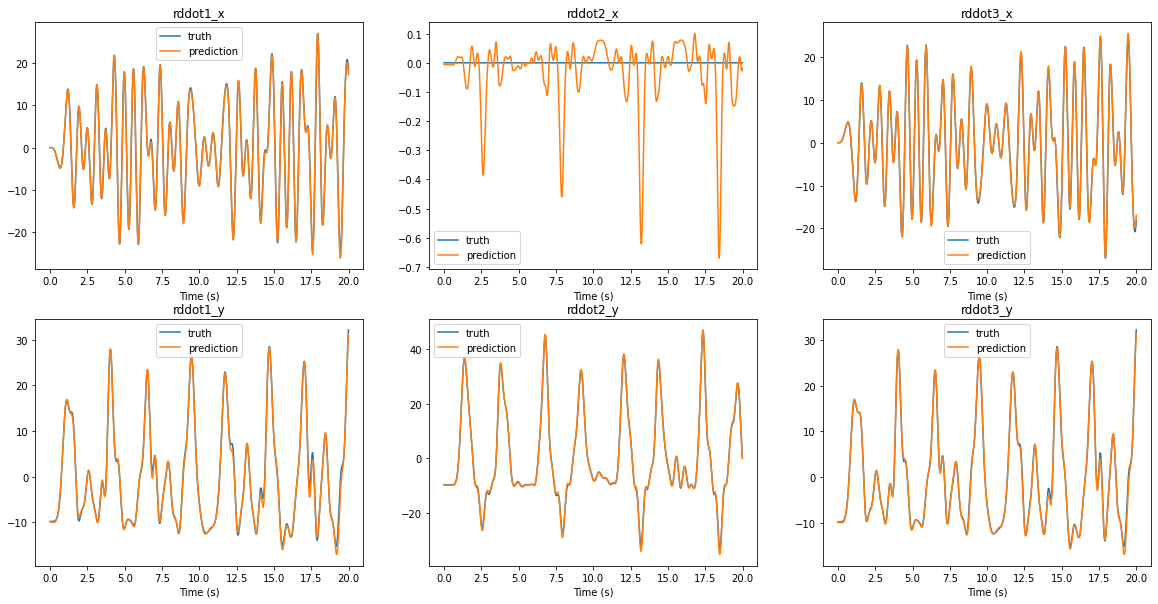

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

f_pred = model.forward(x.requires_grad_()).cpu().detach().numpy()
Nt = df['t'][:2000].size
f_pred = np.hstack((
    f_pred[:Nt],
    f_pred[Nt:2*Nt],
    f_pred[2*Nt:]
))

for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'][:2000], tr_forces[force_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(df['t'][:2000], f_pred[:2000, i], label='prediction')
  curr_ax.set_title(force_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()

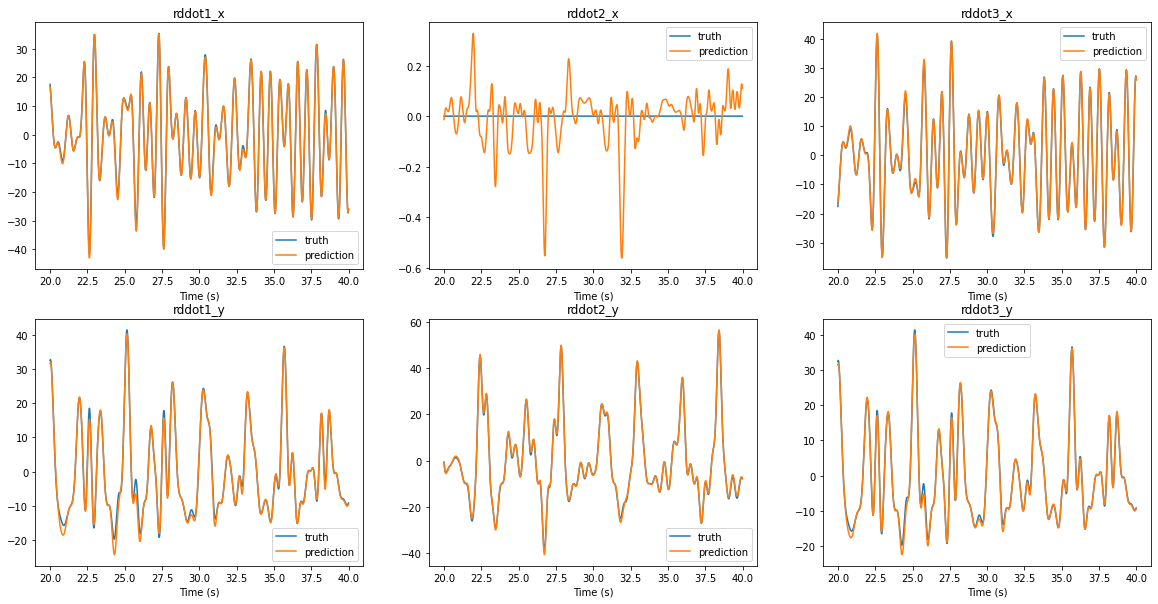

In [34]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

f_pred = model.forward(x_val.requires_grad_()).cpu().detach().numpy()
Nt = df['t'][2000:].size
f_pred = np.hstack((
    f_pred[:Nt],
    f_pred[Nt:2*Nt],
    f_pred[2*Nt:]
))

for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'][2000:], val_forces[force_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(df['t'][2000:], f_pred[:, i], label='prediction')
  curr_ax.set_title(force_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()

# Infer k value

In [35]:
print(f"k in model for training data: {infer_k(model, x_collocation):.2f}")

k in model for training data: 49.80


# Test trained model with different number of masses

In [37]:
te_df = pd.read_csv('../data/k=50_L=5_N=8_T=40s.csv')

te_positions = te_df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y', 'r5_x', 'r5_y', 'r6_x', 'r6_y', 'r7_x', 'r7_y']]
te_forces = te_df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y', 'rddot4_x', 'rddot4_y', 'rddot5_x', 'rddot5_y', 'rddot6_x', 'rddot6_y']]

te_position_stack = np.vstack((
    te_positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    te_positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    te_positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy(),
    te_positions[['r3_x','r3_y','r4_x','r4_y','r5_x','r5_y']].to_numpy(),
    te_positions[['r4_x','r4_y','r5_x','r5_y','r6_x','r6_y']].to_numpy(),
    te_positions[['r5_x','r5_y','r6_x','r6_y','r7_x','r7_y']].to_numpy()
))
te_forces_stack = np.vstack((
    te_forces[['rddot1_x','rddot1_y']].to_numpy(),
    te_forces[['rddot2_x','rddot2_y']].to_numpy(),
    te_forces[['rddot3_x','rddot3_y']].to_numpy(),
    te_forces[['rddot4_x','rddot4_y']].to_numpy(),
    te_forces[['rddot5_x','rddot5_y']].to_numpy(),
    te_forces[['rddot6_x','rddot6_y']].to_numpy()
))

te_x = torch.from_numpy(te_position_stack.copy()).float().to(DEVICE)
te_F = torch.from_numpy(te_forces_stack.copy()).float().to(DEVICE)

In [38]:
# compute NN-predicted closed-loop trajectories
# modify as appropriate:
N_m = 8
xLeft  = (te_positions.iloc[0,:][['r0_x','r0_y']]).to_numpy()
xRight = (te_positions.iloc[0,:][['r7_x','r7_y']]).to_numpy()
mass_cols = ['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y', 'r4_x', 'r4_y', 'r5_x', 'r5_y', 'r6_x', 'r6_y']

# # the vector 'x0' contains the initial positions of the *movable* masses
# # i.e. x0.shape = [N_m * 2]
x0 = (te_positions.iloc[0,:][mass_cols]).to_numpy()
x0dot = np.zeros_like(x0)

y, t = compute_trajectory(x0, x0dot, model, xLeft, xRight)

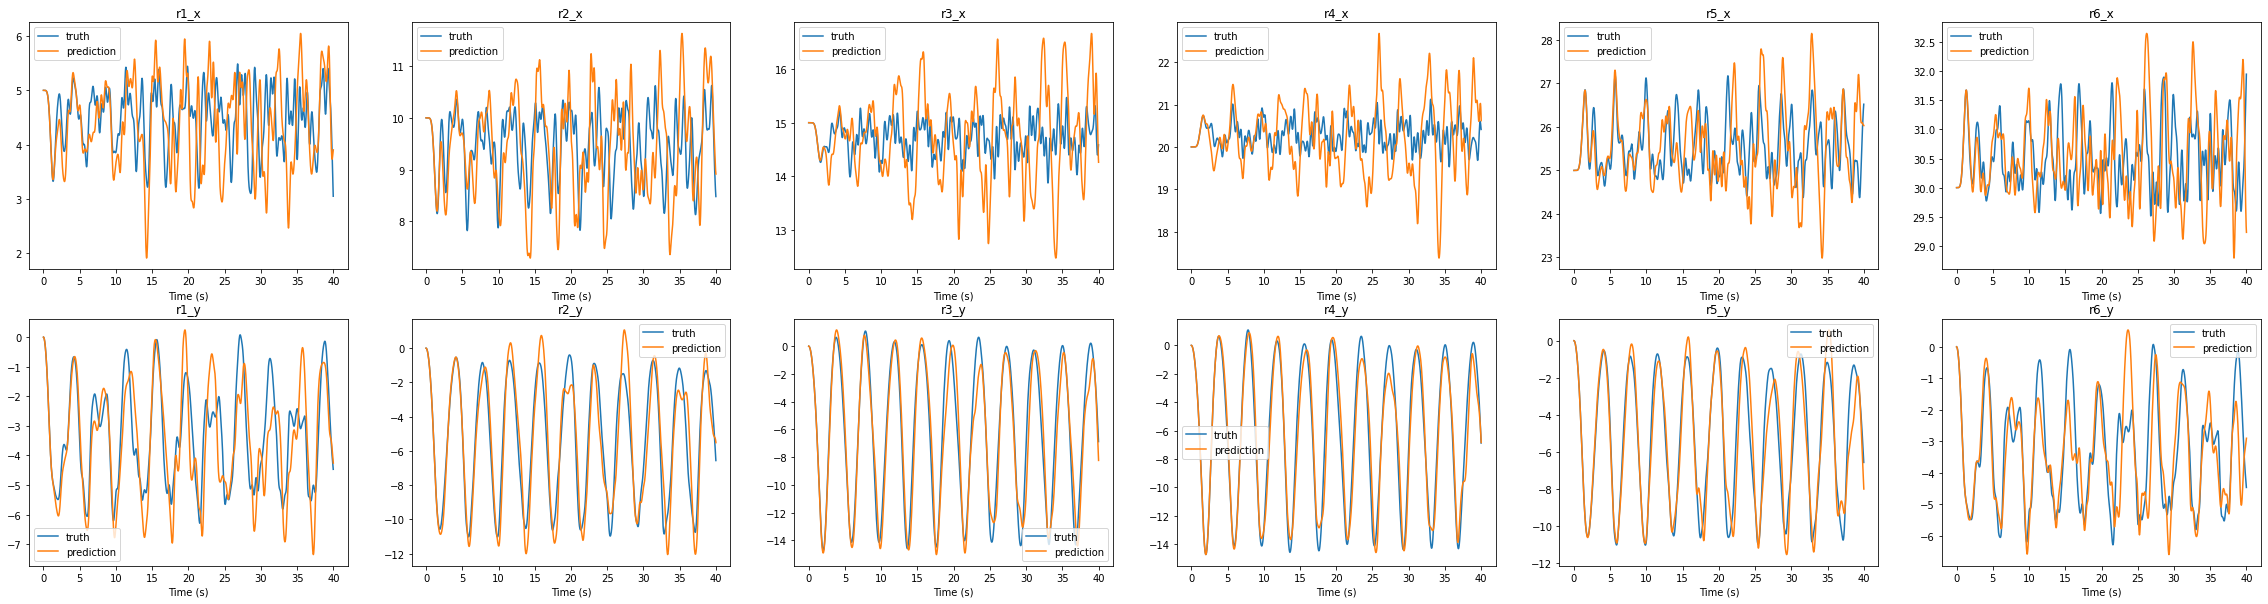

In [41]:
fig, ax = plt.subplots(2, 6, figsize=(40, 10))
for i in range(12):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(te_df['t'], te_positions[mass_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(t, y.T[:,i], label='prediction')
  curr_ax.set_title(mass_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()
  # curr_ax.set_xlim(5, 15)
  # if m == 0:
  #   curr_ax.set_ylim(n * 5, (n+2) * 5)
  # else:
  #   curr_ax.set_ylim(-15, 15)
fig.savefig('test_trajectories_PINN=100_layer=3_dim=32.png')

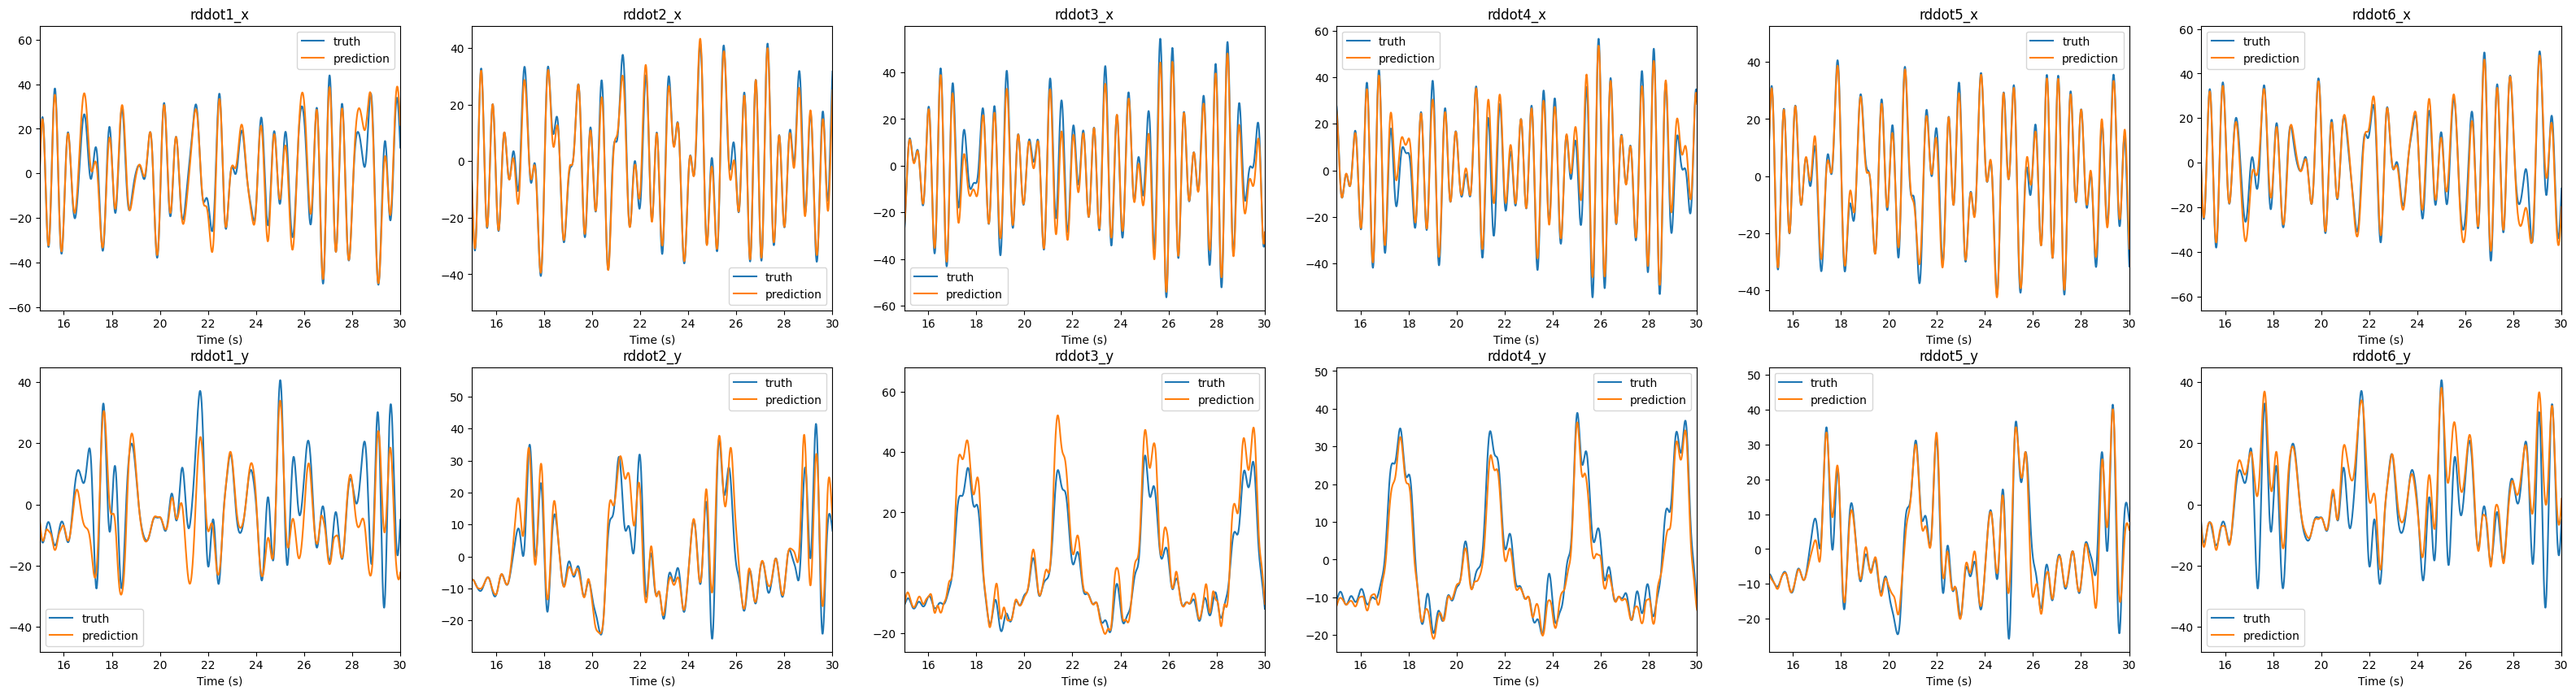

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(40, 10))
force_cols = ['rddot1_x', 'rddot1_y', 'rddot2_x', 'rddot2_y', 'rddot3_x', 'rddot3_y', 'rddot4_x', 'rddot4_y', 'rddot5_x', 'rddot5_y', 'rddot6_x', 'rddot6_y']

f_pred = model.forward(te_x.requires_grad_()).cpu().detach().numpy() #[:, i].detach().numpy()
Nt = te_df['t'].size
f_pred = np.hstack((
    f_pred[:Nt],
    f_pred[Nt:2*Nt],
    f_pred[2*Nt:3*Nt],
    f_pred[3*Nt:4*Nt],
    f_pred[4*Nt:5*Nt],
    f_pred[5*Nt:6*Nt]
))

for i in range(12):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(te_df['t'], te_forces[force_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(te_df['t'], f_pred[:, i], label='prediction')
  curr_ax.set_title(force_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()
  curr_ax.set_xlim(15, 30)